In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit.primitives import Estimator
from qiskit.quantum_info.operators import Operator


from scipy.linalg import expm


# Fabricamos el circuito

## Todos los canales

In [5]:
def teleport (N, b, J, h, g, t, m):
    #Define all functions we'll need
    

    #Creating the Bell Pairs
    left_reg = QuantumRegister(N, 'Left')
    right_reg = QuantumRegister(N, 'Right')
    message_reg = QuantumRegister(m, 'Message')
    
    qc = QuantumCircuit(message_reg, left_reg, right_reg) #quantum circuit
    
    #initalize the TFD 

    def initialize_TFD(qc, beta):
        if beta != 0:
            raise NotImplementedError("Only beta=0 is implemented")
        else:
            for i in range(N):
                qc.h(left_reg[i])
                qc.cx(left_reg[i], right_reg[i])
    
    #Hamiltonian
    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

    H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
    H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()

    #Evolution operator
    def U(h,t):
        U = PauliEvolutionGate(h, time=t, synthesis=LieTrotter(reps=1))
        return U
    
    #Coupling between pairs
    terms_site_V  = ['I'*i + 'Z' + 'I'*(N-1-i)+'I'*i + 'Z' + 'I'*(N-1-i) for i in range(N-1)]

    V=1/(N-m)*sum([SparsePauliOp.from_list([(term, 1)]) for term in terms_site_V])
    V_gate = PauliEvolutionGate(V, time=g, synthesis=LieTrotter(reps=1))


    #Now we do the circuit

    #Bell pairs in a TFD state
    initialize_TFD(qc, 0) 

    
    #Backwards in time
    for _ in range(t):
        qc.append(U(H_K, -1), left_reg)
        qc.append(U(H_I, -1), left_reg)


    #Introduce message
    for i in range(m):
        qc.swap(message_reg[i], left_reg[i])

    #Forwards in time    
    for _ in range(t):
        qc.append(U(H_I, 1), left_reg)
        qc.append(U(H_K, 1), left_reg)

    #Coupling
    qc.append(V_gate, list(range(m, 2*N + m)))


    #Forward in time (right pairs). Que aquí cambia el orden porque la actuación del operador evolución sobre el espacio de la derecha será U_L=U \otimes I -> U_R=I \otimes U^T. U^T=U_K*U_I
    for _ in range(t):
        qc.append(U(H_K, 1), right_reg)
        qc.append(U(H_I, 1), right_reg)


    #Expectation values
    estimator = Estimator()
    res = np.zeros(2*N+m)
   

    for j in range(2*N+m):
        op = SparsePauliOp.from_list([("I"*j + "Z" + "I"*(2*N+m-1-j), 1)])
        print('Channel:', j)

        expectation_value = estimator.run(qc, op).result().values

        res[j] = expectation_value

    return res



## Solo el de salida

In [37]:
def teleport_ch(N, b, J, h, g, t, m):
    #Define all functions we'll need
    

    #Creating the Bell Pairs
    left_reg = QuantumRegister(N, 'Left')
    right_reg = QuantumRegister(N, 'Right')
    message_reg = QuantumRegister(m, 'Message')
    
    qc = QuantumCircuit(message_reg, left_reg, right_reg) #quantum circuit
    
    #initalize the TFD 

    def initialize_TFD(qc, beta):
        if beta != 0:
            raise NotImplementedError("Only beta=0 is implemented")
        else:
            for i in range(N):
                qc.h(left_reg[i])
                qc.cx(left_reg[i], right_reg[i])
    
    #Hamiltonian
    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

    H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
    H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()

    #Evolution operator
    def U(h,t):
        U = PauliEvolutionGate(h, time=t, synthesis=LieTrotter(reps=1))
        return U
    
    #Coupling between pairs
    terms_site_V  = ['I'*i + 'Z' + 'I'*(N-1-i)+'I'*i + 'Z' + 'I'*(N-1-i) for i in range(N-1)]

    V=1/(N-m)*sum([SparsePauliOp.from_list([(term, 1)]) for term in terms_site_V])
    V_gate = PauliEvolutionGate(V, time=g, synthesis=LieTrotter(reps=1))


    #Now we do the circuit

    #Bell pairs in a TFD state
    initialize_TFD(qc, 0) 

    
    #Backwards in time
    for _ in range(t):
        qc.append(U(H_K, -1), left_reg)
        qc.append(U(H_I, -1), left_reg)


    #Introduce message
    for i in range(m):
        qc.swap(message_reg[i], left_reg[i])

    #Forwards in time    
    for _ in range(t):
        qc.append(U(H_I, 1), left_reg)
        qc.append(U(H_K, 1), left_reg)

    #Coupling
    qc.append(V_gate, list(range(m, 2*N + m)))


    #Forward in time (right pairs). Que aquí cambia el orden porque la actuación del operador evolución sobre el espacio de la derecha será U_L=U \otimes I -> U_R=I \otimes U^T. U^T=U_K*U_I
    for _ in range(t):
        qc.append(U(H_K, 1), right_reg)
        qc.append(U(H_I, 1), right_reg)


    #Expectation values
    estimator = Estimator()
   
    op=SparsePauliOp.from_list([("I"*(N-1) + "Z" + "I"*(N+1), 1)])
    
    expectation_value = estimator.run(qc, op).result().values


    return expectation_value

# Pruebas

## BKP* N=3

C:\Users\manue\AppData\Local\Temp\ipykernel_5540\2957047221.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


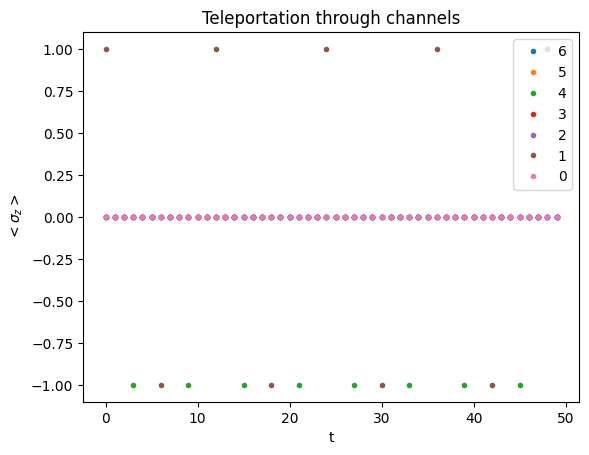

In [18]:
N = 3  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h=np.zeros(N)        # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=50

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]

plt.figure(1)
for i in range(2*N+m):
    plt.plot(t_eval, ch[i],'.', label=str((2*N+m-1)-i))

plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.show()

## h =/ 0

C:\Users\manue\AppData\Local\Temp\ipykernel_5540\2957047221.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


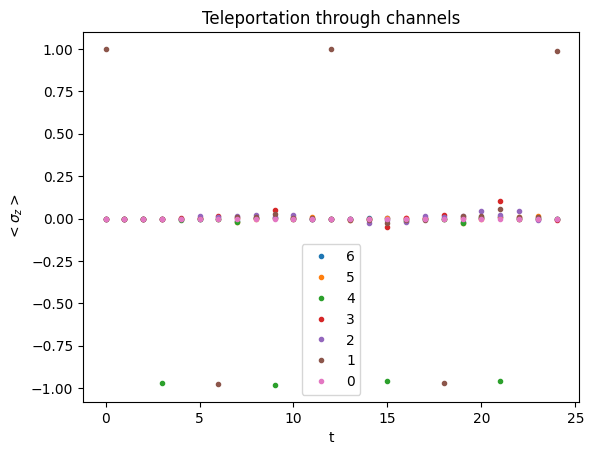

In [21]:
N = 3  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h=np.zeros(N)*0.2        # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=25

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]

plt.figure(1)
for i in range(2*N+m):
    plt.plot(t_eval, ch[i],'.', label=str((2*N+m-1)-i))

plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.show()

C:\Users\manue\AppData\Local\Temp\ipykernel_4032\4002808985.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


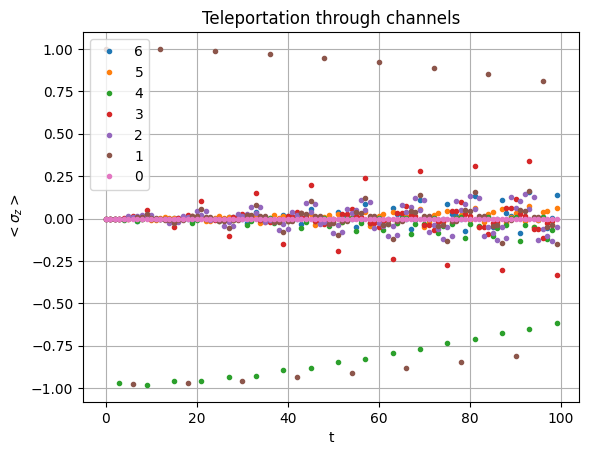

In [7]:
N = 3  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
#h=np.zeros(N)        # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=100

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]

plt.figure(1)
for i in range(2*N+m):
    plt.plot(t_eval, ch[i],'.', label=str((2*N+m-1)-i))

plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.grid()
plt.savefig('Sigmaz vs t N=3.png', dpi=400)
plt.show()

C:\Users\manue\AppData\Local\Temp\ipykernel_21272\4208148260.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


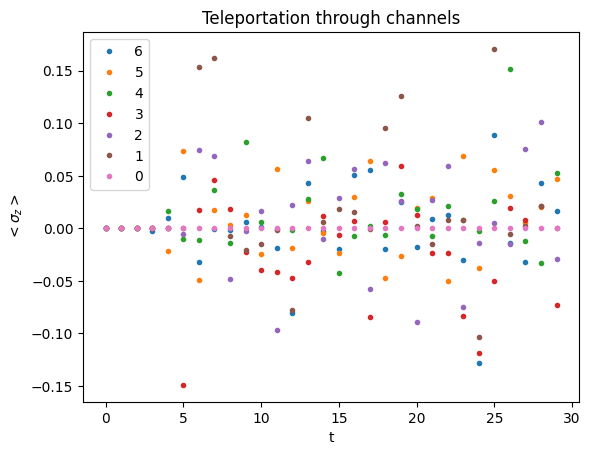

In [7]:
N = 3  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h = np.array([0.0916079, 0.119953 ,0.0983397]) 
#h=np.zeros(N)        # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=30

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]

plt.figure(1)
for i in range(2*N+m):
    plt.plot(t_eval, ch[i],'.', label=str((2*N+m-1)-i))

plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.show()

C:\Users\manue\AppData\Local\Temp\ipykernel_21272\1885986621.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


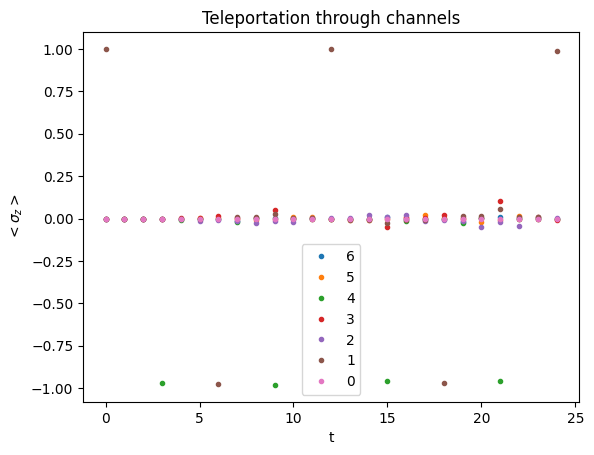

In [3]:
N = 3  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h = np.array([0.0316079, -0.0519953 ,0.0283397]) 
#h=np.zeros(N)        # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=25

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]

plt.figure(1)
for i in range(2*N+m):
    plt.plot(t_eval, ch[i],'.', label=str((2*N+m-1)-i))

plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.show()

## BKP* N=4

C:\Users\manue\AppData\Local\Temp\ipykernel_5540\1885986621.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


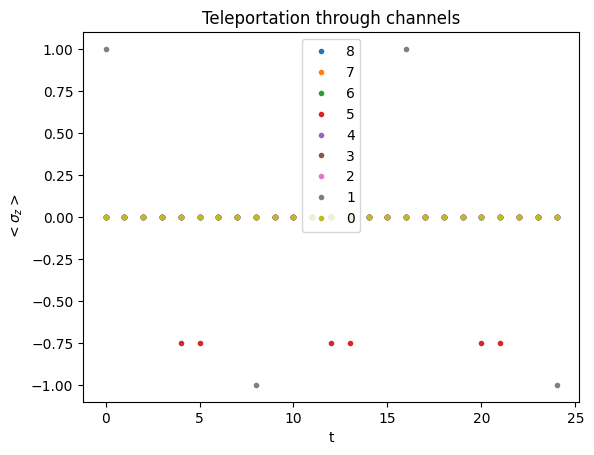

In [30]:
N = 4  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h=np.zeros(N)        # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=25

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]

plt.figure(1)
for i in range(2*N+m):
    plt.plot(t_eval, ch[i],'.', label=str((2*N+m-1)-i))

plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.show()

## BKP* N=5 m=2

C:\Users\manue\AppData\Local\Temp\ipykernel_5540\1885986621.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


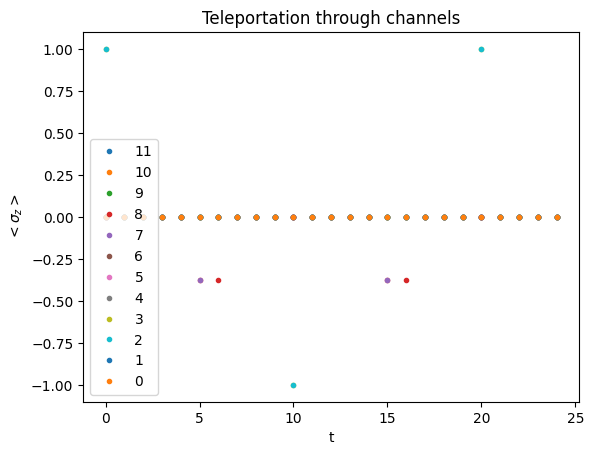

In [33]:
N = 5  # number of qubits per side
m = 2  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h=np.zeros(N)        # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=25

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]

plt.figure(1)
for i in range(2*N+m):
    plt.plot(t_eval, ch[i],'.', label=str((2*N+m-1)-i))

plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.show()

[1, 2, 3, 4, 5, 6]

## N=10?

In [3]:
N = 7  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
# h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h=np.zeros(N)*0.2        # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=25

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]



C:\Users\manue\AppData\Local\Temp\ipykernel_17672\4002808985.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


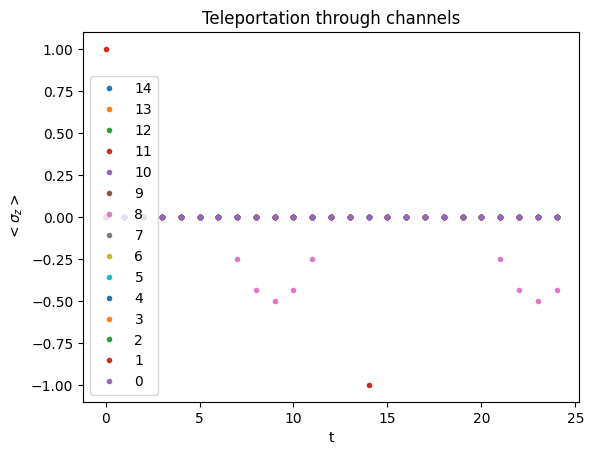

In [4]:
plt.figure(1)
for i in range(2*N+m):
    plt.plot(t_eval, ch[i],'.', label=str((2*N+m-1)-i))

plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.show()

In [6]:
N = 7  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
# h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h = np.random.rand(N)*0.2 # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=25

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]


C:\Users\manue\AppData\Local\Temp\ipykernel_17672\4002808985.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


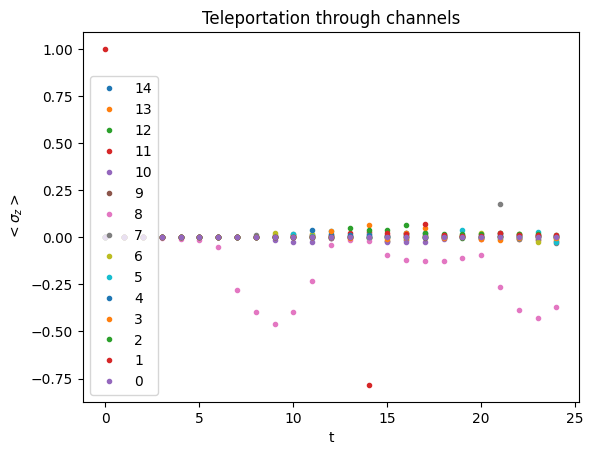

In [7]:
plt.figure(1)
for i in range(2*N+m):
    plt.plot(t_eval, ch[i],'.', label=str((2*N+m-1)-i))

plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.show()

In [35]:
N = 8  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
# h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h = np.random.rand(N)*0.2 # magnetic field
g = np.pi / 2  # interaction coupling strength

t_max=50

t_eval=list(range(t_max))

ch=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    print(t)
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch[j,t]=res[j]

0
Channel: 0
Channel: 1


C:\Users\manue\AppData\Local\Temp\ipykernel_208\970329693.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
1
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
2
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
3
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
4
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
5
Channel: 0
Channel: 1
Channel: 2
Channel: 

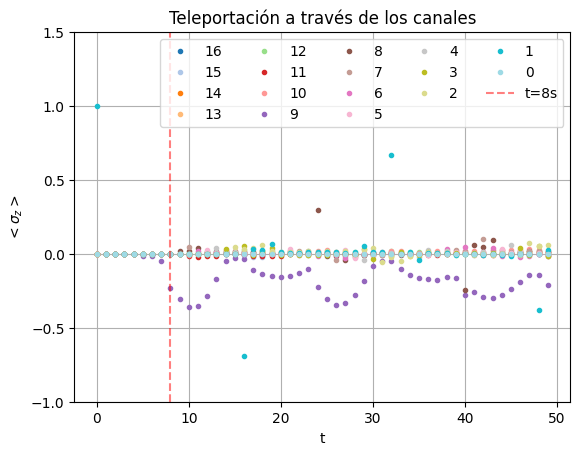

In [53]:
colors = plt.cm.tab20(np.linspace(0, 1, 2*N+m))

plt.figure(1)
for i in range(2*N+m):
    plt.plot(range(50), ch[i],'.',color=colors[i], label=str((2*N+m-1)-i))
plt.axvline(x=8, color='red', linestyle='--',label='t=8s',alpha=0.5)
plt.title(r'Teleportación a través de los canales')
plt.legend(loc='upper right',ncol=5)
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.ylim(-1, 1.5)
plt.grid()
plt.savefig(f'sigmaz vs time N={N}.pdf', dpi=400)  # Save the plot as PDF
plt.show()

In [32]:
N = 8  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
# h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h = np.random.rand(N)*0.05 # magnetic field

g = np.pi / 2  # interaction coupling strength

t_max=200

t_eval=list(range(101))

ch=np.zeros((2*N+m, len(t_eval)))
ch_tp=[]
for i,t in enumerate(t_eval):
    print(t)
    res=teleport_ch(N,b,J,h,g,t,m)
    ch_tp.append(res)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


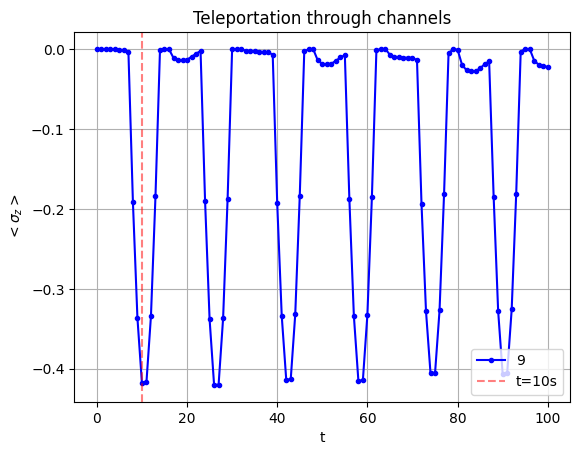

In [33]:
colors = plt.cm.tab20(np.linspace(0, 1, 2*N+m))

plt.figure(1)

plt.plot(range(101), ch_tp,'.-',color='blue', label=str((N+1)))
plt.axvline(x=10, color='red', linestyle='--',label='t=10s',alpha=0.5)
plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.grid()
plt.savefig(f'sigmaz vs time N={N} chanel of tp t 100 h chiko.pdf', dpi=400)  # Save the plot as PDF
plt.show()

In [39]:
N = 8  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = (np.pi / 4)-0.1  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
# h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h = np.random.rand(N)*0.2 # magnetic field

g = np.pi / 2  # interaction coupling strength

t_max=200

t_eval=list(range(56))

ch_b=[]
for i,t in enumerate(t_eval):
    print(t)
    res=teleport_ch(N,b,J,h,g,t,m)
    ch_b.append(res)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


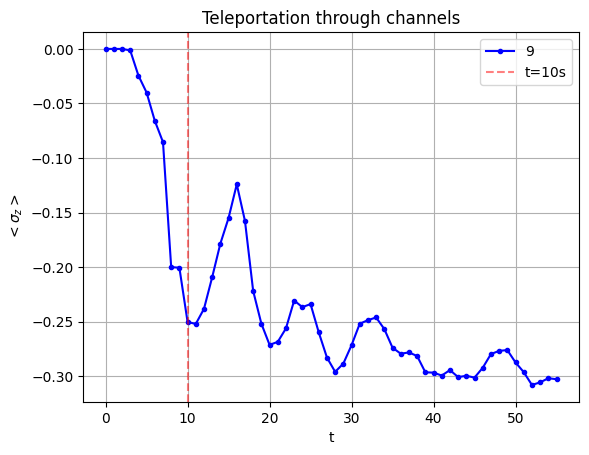

In [41]:
colors = plt.cm.tab20(np.linspace(0, 1, 2*N+m))

plt.figure(4)

plt.plot(range(56), ch_b,'.-',color='blue', label=str((N+1)))
plt.axvline(x=10, color='red', linestyle='--',label='t=10s',alpha=0.5)
plt.title(r'Teleportation through channels')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$<\sigma_z>$')
plt.grid()
plt.savefig(f'sigmaz vs time N={N} fuera bkp estrella.pdf', dpi=400)  # Save the plot as PDF
plt.show()

# h Bien (TFG)

In [81]:
N = 8  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = (np.pi / 4)  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
# h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h=np.array([0.01044837, 0.05760976, 0.07093719, 0.15558772, 0.07337934, 0.00437979, 0.02806242, 0.11174344])
g = np.pi / 2  # interaction coupling strength

t_max=151

t_eval=list(range(t_max))

ch_bien3=[]
for i,t in enumerate(t_eval):
    print(t)
    res=teleport_ch(N,b,J,h,g,t,m)
    ch_bien3.append(res)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


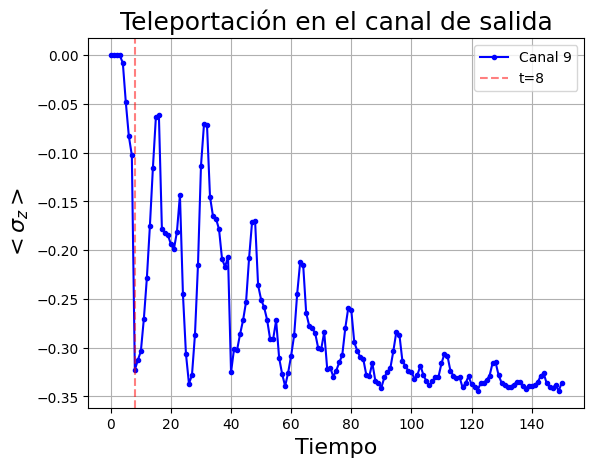

In [108]:

colors = plt.cm.tab20(np.linspace(0, 1, 2*N+m))

plt.figure(4)

plt.plot(range(151), ch_bien3,'.-',color='blue', label='Canal 9')
plt.axvline(x=8, color='red', linestyle='--',label='t=8',alpha=0.5)
plt.title(r'Teleportación en el canal de salida', fontsize=18)
plt.legend()
plt.xlabel('Tiempo', fontsize=16)
plt.ylabel(r'$<\sigma_z>$', fontsize=16)
plt.grid()
plt.savefig(f'sigmaz vs time N={N} h bien PRUEBAS.pdf', dpi=400)  # Save the plot as PDF
plt.show()

## Total

In [86]:
N = 8  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
# h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h=np.array([0.01044837, 0.05760976, 0.07093719, 0.15558772, 0.07337934, 0.00437979, 0.02806242, 0.11174344])
g = np.pi / 2  # interaction coupling strength

t_max=51

t_eval=list(range(t_max))

ch_total2=np.zeros((2*N+m, len(t_eval)))
for t in t_eval:
    print(t)
    res=teleport(N,b,J,h,g,t,m)

    for j in range(2*N+m):
        ch_total2[j,t]=res[j]

0
Channel: 0
Channel: 1
Channel: 2


C:\Users\manue\AppData\Local\Temp\ipykernel_208\970329693.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res[j] = expectation_value


Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
1
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
2
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
3
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
4
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 4
Channel: 5
Channel: 6
Channel: 7
Channel: 8
Channel: 9
Channel: 10
Channel: 11
Channel: 12
Channel: 13
Channel: 14
Channel: 15
Channel: 16
5
Channel: 0
Channel: 1
Channel: 2
Channel: 3
Channel: 

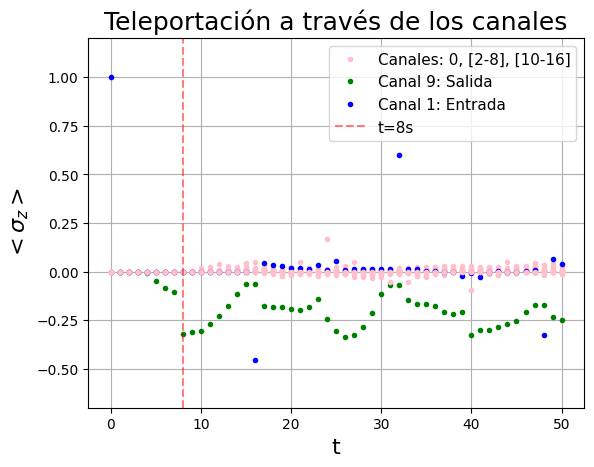

In [117]:
#Plots

colors = plt.cm.tab20(np.linspace(0, 1, 2*N+m))
colors=['pink','pink','pink','pink','pink','pink','pink','green','pink','pink','pink','pink','pink','pink','pink','blue','pink']
labels=['Canales: 0, [2-8], [10-16]','','','','','','','Canal 9: Salida','','','','','','','','Canal 1: Entrada','']
plt.figure(7)
for i in range(2*N+m):
    plt.plot(range(51), ch_total2[i],'.',color=colors[i],label=labels[i])
plt.axvline(x=8, color='red', linestyle='--',label='t=8s',alpha=0.5)
plt.title(r'Teleportación a través de los canales', fontsize=18)
plt.legend(loc='upper right',ncol=1,fontsize=11)
plt.xlabel('t', fontsize=16)
plt.ylabel(r'$<\sigma_z>$', fontsize=16)
plt.ylim(-0.7, 1.2)
plt.grid()
plt.savefig(f'sigmaz vs time N={N} weno.pdf', dpi=400)  # Save the plot as PDF
plt.show()

## Fuera BKP*


In [87]:
N = 8  # number of qubits per side
m = 1  # message size single qubit

# Simulation parameters
np.random.seed(1)  # seed to reproduce h samplings
J = np.pi / 4  # ZZ rotation strength
# h = np.array([0.0316079, 0.0519953 ,0.0283397]) 
h=np.array([0.01044837, 0.05760976, 0.07093719, 0.15558772, 0.07337934, 0.00437979, 0.02806242, 0.11174344])
g = np.pi / 2  # interaction coupling strength
b = np.linspace((np.pi/4)-0.15, (np.pi/4), 15)

t_max=101

t_eval=list(range(t_max))

ch_fuera=[]

for bp in b:
    ch_temp=[]
    for i,t in enumerate(t_eval):
        print(t)
        res=teleport_ch(N,bp,J,h,g,t,m)
        ch_temp.append(res)
    ch_fuera.append(ch_temp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42

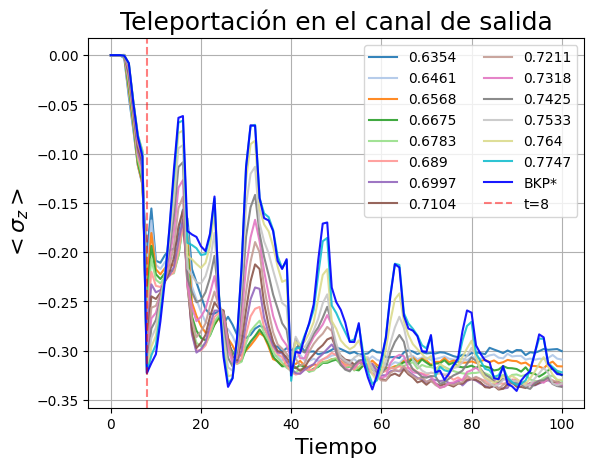

In [107]:
#plots
alphas=np.linspace(0.4,0.9,15)

colors = plt.cm.tab20(np.linspace(0, 1, len(b)))

plt.figure(5)

for i in range(len(b)-1):
    plt.plot(range(101), ch_fuera[i],'-',color=colors[i], label=f'{np.round(b[i],4)}',alpha=0.9)
plt.plot(range(101), ch_fuera[-1],'-',color='blue', label='BKP*',alpha=0.9)

plt.axvline(x=8, color='red', linestyle='--',label='t=8',alpha=0.5)
plt.title(r'Teleportación en el canal de salida', fontsize=18)
plt.legend(loc='upper right',ncol=2)
plt.xlabel('Tiempo', fontsize=16)
plt.ylabel(r'$<\sigma_z>$', fontsize=16)
plt.grid()
plt.savefig(f'sigmaz vs time N={N} h bien fuera bkp.pdf', dpi=400)  # Save the plot as PDF
plt.show()